In [2]:
import numpy as np
import pandas as pd   
from matplotlib import pyplot as plt
import seaborn as sns
from sklearn import linear_model
from sklearn.model_selection import train_test_split
import torch
import itertools

import pyro
import pyro.distributions as dist
from pyro.contrib.autoguide import AutoDiagonalNormal, AutoMultivariateNormal
from pyro.infer import MCMC, NUTS, HMC, SVI, Trace_ELBO
from pyro.optim import Adam, ClippedAdam

from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
# fix random generator seed (for reproducibility of results)
np.random.seed(42)
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

# matplotlib options
palette = itertools.cycle(sns.color_palette())
plt.style.use('ggplot')
%matplotlib inline
plt.rcParams['figure.figsize'] = (16, 10)

In [3]:
df = pd.read_csv("Data/2018.csv")

In [4]:
df.FL_DATE = pd.to_datetime(df.FL_DATE, format="%Y-%m-%d")
df = df.set_index('FL_DATE')

In [5]:
df = df.loc['2018-01-01':'2018-03-01']

In [6]:
df.tail()

,OP_CARRIER,OP_CARRIER_FL_NUM,ORIGIN,DEST,CRS_DEP_TIME,DEP_TIME,DEP_DELAY,TAXI_OUT,WHEELS_OFF,WHEELS_ON,...,CRS_ELAPSED_TIME,ACTUAL_ELAPSED_TIME,AIR_TIME,DISTANCE,CARRIER_DELAY,WEATHER_DELAY,NAS_DELAY,SECURITY_DELAY,LATE_AIRCRAFT_DELAY,Unnamed: 27
FL_DATE,,,,,,,,,,,,,,,,,,,,,
2018-03-01,UA,203,BOS,ORD,652,651.0,-1.0,20.0,711.0,853.0,...,179.0,198.0,162.0,867.0,0.0,0.0,18.0,0.0,0.0,NaN
2018-03-01,UA,202,ORD,OGG,1020,1028.0,8.0,45.0,1113.0,1606.0,...,567.0,583.0,533.0,4184.0,8.0,0.0,16.0,0.0,0.0,NaN
2018-03-01,UA,201,HNL,GUM,1510,1505.0,-5.0,20.0,1525.0,1855.0,...,475.0,473.0,450.0,3801.0,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01,UA,200,GUM,HNL,735,744.0,9.0,12.0,756.0,1822.0,...,415.0,406.0,386.0,3801.0,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01,UA,102,IAH,RDU,1940,1934.0,-6.0,14.0,1948.0,2247.0,...,161.0,139.0,119.0,1042.0,NaN,NaN,NaN,NaN,NaN,NaN


In [7]:
df.dtypes

OP_CARRIER              object
OP_CARRIER_FL_NUM        int64
ORIGIN                  object
DEST                    object
CRS_DEP_TIME             int64
DEP_TIME               float64
DEP_DELAY              float64
TAXI_OUT               float64
WHEELS_OFF             float64
WHEELS_ON              float64
TAXI_IN                float64
CRS_ARR_TIME             int64
ARR_TIME               float64
ARR_DELAY              float64
CANCELLED              float64
CANCELLATION_CODE       object
DIVERTED               float64
CRS_ELAPSED_TIME       float64
ACTUAL_ELAPSED_TIME    float64
AIR_TIME               float64
DISTANCE               float64
CARRIER_DELAY          float64
WEATHER_DELAY          float64
NAS_DELAY              float64
SECURITY_DELAY         float64
LATE_AIRCRAFT_DELAY    float64
Unnamed: 27            float64
dtype: object

In [8]:
df = df.fillna(0)

(array([7.08836e+05, 3.40467e+05, 4.69800e+04, 9.57700e+03, 2.92000e+03,
        1.20900e+03, 4.92000e+02, 2.38000e+02, 1.02000e+02, 2.70000e+01]),
 array([  0. ,  17.8,  35.6,  53.4,  71.2,  89. , 106.8, 124.6, 142.4,
        160.2, 178. ]),
 <BarContainer object of 10 artists>)

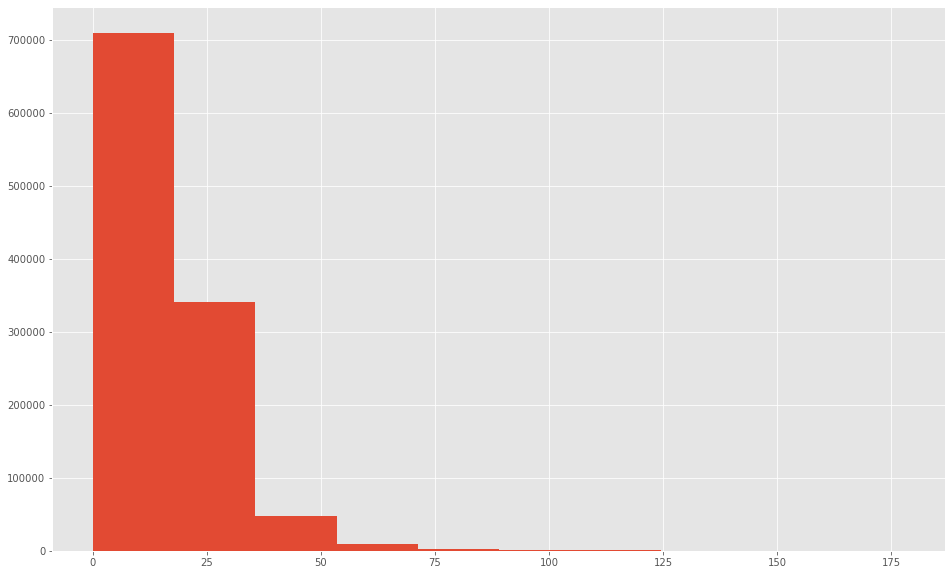

In [9]:
plt.hist(df["TAXI_OUT"])



In [10]:
X_features = np.concatenate([pd.get_dummies(df[x]) for x in ["ORIGIN", "DEST"]], axis=1)
df = df.drop(columns=['ORIGIN', 'DEST'])
X = np.concatenate([df[["TAXI_OUT"]], X_features], axis=1)
print(X_features.shape)
y = df["CARRIER_DELAY"].values


(1110848, 674)


In [11]:
print(X_features.shape)


(1110848, 674)


In [12]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)


# standardize input features
X_train_mean = X_train.mean(axis=0)
X_train_std = X_train.std(axis=0)
X_train = (X_train - X_train_mean) / X_train_std

X_test_mean = X_test.mean(axis=0)
X_test_std = X_test.std(axis=0)
X_test = (X_test - X_test_mean) / X_test_std

# standardize target
y_train_mean = y_train.mean()
y_train_std = y_train.std()
y_train = (y_train - y_train_mean) / y_train_std

y_test_mean = y_test.mean()
y_test_std = y_test.std()
y_test = (y_test - y_test_mean) / y_test_std


KeyboardInterrupt: 

In [ ]:
print("num train: %d" % len(y_train))
print("num test: %d" % len(y_test))

num train: 744268
num test: 366580


In [ ]:
def compute_error(trues, predicted):
    corr = np.corrcoef(predicted, trues)[0,1]
    mae = np.mean(np.abs(predicted - trues))
    rae = np.sum(np.abs(predicted - trues)) / np.sum(np.abs(trues - np.mean(trues)))
    rmse = np.sqrt(np.mean((predicted - trues)**2))
    r2 = max(0, 1 - np.sum((trues-predicted)**2) / np.sum((trues - np.mean(trues))**2))
    return corr, mae, rae, rmse, r2

In [ ]:

regr = linear_model.LinearRegression()
regr.fit(X_train, y_train)
y_hat = regr.predict(X_test)




corr, mae, rae, rmse, r2 = compute_error(y_test, y_hat)
print("CorrCoef: %.3f\nMAE: %.3f\nRMSE: %.3f\nR2: %.3f" % (corr, mae, rmse, r2))

CorrCoef: 0.001
MAE: 356234964.496
RMSE: 591449137.985
R2: 0.000


REALLY bad model

In [15]:
X.shape[1]

675

First a model with TAXI_OUT, DESTINATION and ORIGIN as inpot with same regression coefficients

In [16]:
def model(X, obs=None):
    #gp = pyro.sample("gp", dist.Gamma(k,theta))
    alpha = pyro.sample("alpha", dist.Normal(0., 1.))                   # Prior for the bias/intercept
    beta  = pyro.sample("beta", dist.Normal(torch.zeros(X.shape[1]), 
                                            torch.ones(X.shape[1])).to_event())    # Priors for the regression coeffcients
    sigma = pyro.sample("sigma", dist.HalfCauchy(5.))                   # Prior for the variance
    
    with pyro.plate("data"):
        y = pyro.sample("y", dist.Normal(alpha + X.matmul(beta), sigma), obs=obs)
        
    return y

In [17]:
# Prepare data for Pyro model
X_train_small = torch.tensor(X_train[:100,:]).float()
y_train_small = torch.tensor(y_train[:100]).float()

In [18]:
X_train_small

tensor([[ 6.1426e-01, -2.3420e-02, -1.7038e-02,  ..., -1.0106e-02,
         -1.1591e-03, -1.4103e-02],
        [ 1.4740e-01, -2.3420e-02, -1.7038e-02,  ..., -1.0106e-02,
         -1.1591e-03, -1.4103e-02],
        [-1.6267e+00, -2.3420e-02, -1.7038e-02,  ..., -1.0106e-02,
         -1.1591e-03, -1.4103e-02],
        ...,
        [-5.9959e-01, -2.3420e-02, -1.7038e-02,  ..., -1.0106e-02,
         -1.1591e-03, -1.4103e-02],
        [-5.0621e-01, -2.3420e-02, -1.7038e-02,  ..., -1.0106e-02,
         -1.1591e-03, -1.4103e-02],
        [-3.9350e-02, -2.3420e-02, -1.7038e-02,  ..., -1.0106e-02,
         -1.1591e-03, -1.4103e-02]])

In [19]:
# Run inference in Pyro
nuts_kernel = NUTS(model)
mcmc = MCMC(nuts_kernel, num_samples=1000, warmup_steps=200, num_chains=1)
mcmc.run(X_train_small, y_train_small)

# Show summary of inference results
mcmc.summary()


Sample: 100%|██████████| 1200/1200 [03:50,  5.20it/s, step size=3.93e-02, acc. prob=0.946]



                mean       std    median      5.0%     95.0%     n_eff     r_hat
     alpha      0.12      0.77      0.12     -1.11      1.42    664.51      1.00
   beta[0]     -0.12      0.49     -0.12     -0.86      0.70    763.60      1.00
   beta[1]      0.01      1.02     -0.01     -1.65      1.65   2567.83      1.00
   beta[2]     -0.01      1.03     -0.01     -1.79      1.56   2800.59      1.00
   beta[3]     -0.00      0.35      0.00     -0.60      0.55    798.40      1.00
   beta[4]      0.03      0.95     -0.00     -1.51      1.59   1379.60      1.00
   beta[5]      0.04      1.02      0.03     -1.62      1.79   2773.32      1.00
   beta[6]     -0.01      1.08     -0.03     -1.81      1.77   2511.69      1.00
   beta[7]      0.01      1.01     -0.00     -1.71      1.64   3116.12      1.00
   beta[8]      0.01      0.11      0.00     -0.17      0.19    904.85      1.00
   beta[9]      0.01      1.03      0.05     -1.58      1.74   2978.68      1.00
  beta[10]      0.01      0

c:\Users\jcrl\miniconda3\envs\ModelML\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
c:\Users\jcrl\miniconda3\envs\ModelML\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


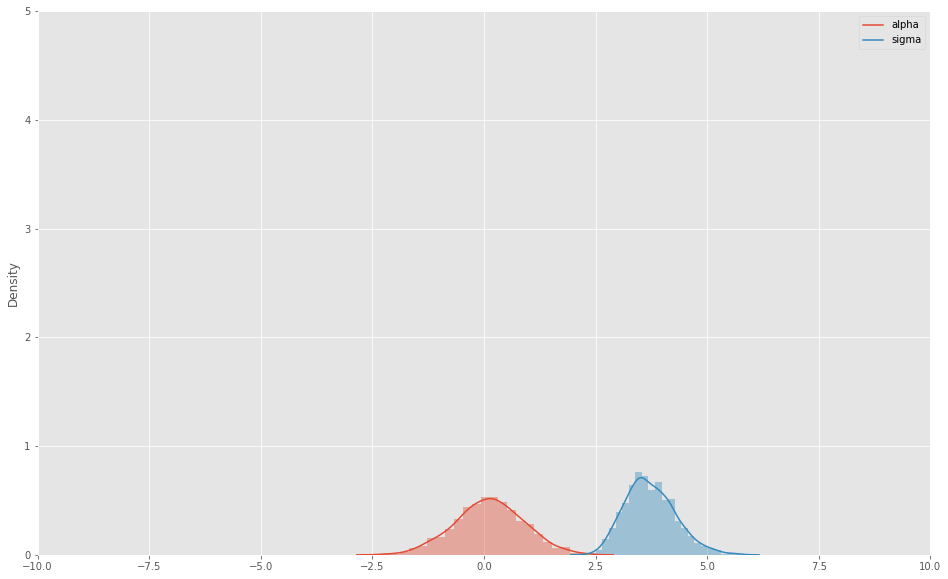

In [22]:
# Extract samples from posterior
posterior_samples = mcmc.get_samples()

sns.distplot(posterior_samples["alpha"])
sns.distplot(posterior_samples["sigma"])

# Alternate plotting due to deprecated distplot-function
#sns.histplot(data=posterior_samples["alpha"], kde=True, stat='density', color=next(palette), element="step")
#sns.histplot(data=posterior_samples["sigma"], kde=True, stat='density', color=next(palette), element="step")

plt.legend(["alpha", "sigma"])
plt.axis([-10,10,0,5])
plt.show()


In [1]:
for i in range(X.shape[1]):
    sns.distplot(posterior_samples["beta"][:,i])

    # Alternative to avoid warnings
    #sns.histplot(posterior_samples["beta"][:,i], kde=True, color=next(palette), stat='density', element='step')

plt.axis([-2,2,0,5])
plt.show()

NameError: name 'X' is not defined

In [26]:
print(posterior_samples["alpha"].shape)
print(posterior_samples["beta"].shape)

beta_hat=torch.mean(posterior_samples["beta"], axis=0)
alpha_hat=torch.mean(posterior_samples["alpha"], axis=0)

y_hat = alpha_hat+np.dot(X_test,beta_hat)

torch.Size([1000])
torch.Size([1000, 675])


In [28]:
# Convert back to the original scale
preds = y_hat.numpy() * y_test_std + y_test_mean
y_true = y_test * y_test_std + y_test_mean

corr, mae, rae, rmse, r2 = compute_error(y_true, preds)
print("CorrCoef: %.3f\nMAE: %.3f\nRMSE: %.3f\nR2: %.3f" % (corr, mae, rmse, r2))

CorrCoef: -0.003
MAE: 35.843
RMSE: 59.861
R2: 0.000
